Consider a rocket constrained to an environment (operational space) that is a vertical 2D slice through the world (i.e. coordinate axes left-right, up-down; gravity always points down). The rocket body B produces a noisy thrust force F along its own axis, but has an off-center control mass C to be used for control.

That is, the rocket consists of a rigid body mB and a point mass mC separated by a time varying vector d0 + r(t)d1 from the center of mass of B (in the B reference frame). It also produces a force F + w(t) in the B reference frame, where w is the unknown disturbance. The configuration state variable r(t) is limited to the range [−1, 1], and the single DOF input u(t) controls the acceleration (second derivative) of r(t): r''(t) = u(t). Mathematically formulate this system, and simulate / visualize it’s behavior through the 2D
(3DOF) operational space.

In [3]:
# Imports
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib
matplotlib.rcParams.update({'font.size':16})

In [16]:
# Time constants
t0 = 0 # Start time
tf = 100 # End time
dt = 0.001 # Time step (in diff. eq. solver)
length = int(tf/dt)+1 # Number of steps in time interval
tvec = np.linspace(0,tf,length)

# Constants
mB = 10
mC = 0.1
g = 9.8
F = 5*g*(mB + mC)
d0 = 1
d1 = 1/25

I0 = (mB*mC/(mB + mC)) * (d0**2)

# Control inputs:
theta1_t = 5*(2*np.pi/360) # Offset in radians
theta2_t = 0
r2_t = 0

kP_theta = I0/2
# kD_theta = kP_theta/4
kD_theta = 0.35
kP_r = 2
# kD_r = kP_r/4
kD_r = 0.5

In [21]:
# Solving the equations of motion
i = 0 # Iteration counter
ti = t0 # Time counter

# Initializations
x1 = np.zeros((length))
x2 = np.zeros((length))
y1 = np.zeros((length))
y2 = np.zeros((length))
theta1 = np.zeros((length))
theta2 = np.zeros((length))
r1 = np.zeros((length))
r2 = np.zeros((length))
u = np.zeros((length))

# Initializations
x1_p = np.zeros((length))
x2_p = np.zeros((length))
y1_p = np.zeros((length))
y2_p = np.zeros((length))
theta1_p = np.zeros((length))
theta2_p = np.zeros((length))
r1_p = np.zeros((length))
r2_p = np.zeros((length))

# Iterate over time interval
# Since we compute the (i+1)th outputs at state i, stop one step early.
for ti in tvec[0:-1]:

    # Add noise to the thrust:
    w = np.random.normal(0,F/10) # Gaussian noise
    Fw = F # Don't include noise
    # Fw = F + w # Include noise

    # Double-loop PD Controller   
    r1_t = -kP_theta*(theta1[i] - theta1_t) - kD_theta*(theta2[i] - theta2_t)
    u[i] = - kP_r*(r1[i] - r1_t) - kD_r*(r2[i] - r2_t)
    # u[i] = u[i] + (Fw*d1/(mB*d0))*r1[i] # Canceling the nonlinearity

    # Old torque calculations:
    # theta2_p[i] = (mC*Fw*d1*r1[i])/(mB*mC*(d0**2 + (d1*r1[i])**2))
    # theta2_p[i] = (Fw*d1*r1[i] - mB*d0*u[i])/(mB*(d0**2 + (d1*r1[i])**2))

    # Torque calculations:
    L = np.sqrt(d0**2 + (r1[i]*d1)**2)
    I = (mB*mC/(mB+mC))*(L**2) # Moment of inertia
    if r1[i] == 0:
      Tau_thrust = 0 # Torque due to thrust
      Tau_reaction = (mC/(mB+mC))*d0*mC*u[i] # Torque due to reaction force
    else:
      X = (mC/(mB+mC))*L
      # sinphi = d1*r1[i]/L
      G = X*d1*r1[i]/L
      P = d0*d1*r1[i]/L
      Q = d0**2/L
      R = Q - X
      T = np.sqrt(P**2 + R**2)
      Phi = np.arctan(r1[i]*d1/d0)
      Psi = np.arctan(R/P)
      Xi = np.pi/2 - Phi - Psi
      # Nu = np.sqrt(G**2 + T**2)
      T = np.sqrt(P**2 + R**2)
      Tau_thrust = Fw*G # Torque due to thrust
      Tau_reaction = mC*np.cos(Xi)*T*u[i] # Torque due to reaction force
    Tau = Tau_thrust # Total torque (ignoring reaction force)
    # Tau = Tau_thrust + Tau_reaction # Total torque (including reaction force)

    # Equations of Motion
    y1_p[i] = y2[i]
    y2_p[i] = (Fw/(mB+mC))*np.cos(theta1[i]) - g
    x1_p[i] = x2[i]
    x2_p[i] = (Fw/(mB+mC))*np.sin(theta1[i])
    theta1_p[i] = theta2[i]
    theta2_p[i] = Tau/I
    r1_p[i] = r2[i]
    r2_p[i] = u[i]
    
    # Euler Approx.
    y1[i+1] = y1[i] + y1_p[i]*dt
    y2[i+1] = y2[i] + y2_p[i]*dt
    x1[i+1] = x1[i] + x1_p[i]*dt
    x2[i+1] = x2[i] + x2_p[i]*dt
    theta1[i+1] = theta1[i] + theta1_p[i]*dt
    theta2[i+1] = theta2[i] + theta2_p[i]*dt
    r1[i+1] = r1[i] + r1_p[i]*dt
    r2[i+1] = r2[i] + r2_p[i]*dt

    i += 1

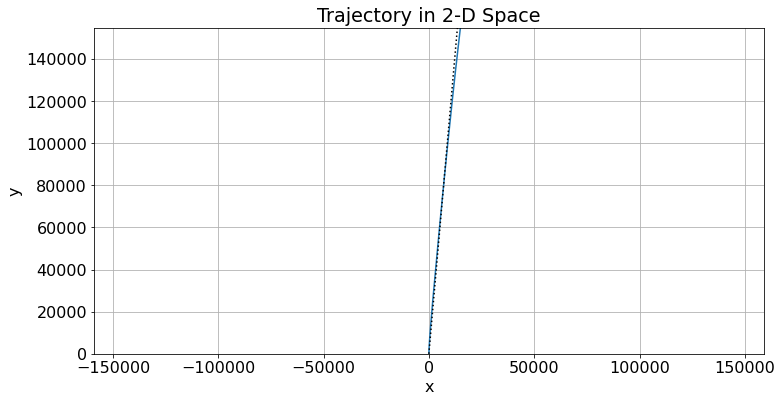

In [22]:
x_t = np.linspace(0,np.max(y1),length)
y_t = np.tan(np.pi/2 - theta1_t)*x_t

plt.plot(x1,y1)
plt.plot(x_t,y_t,linestyle="dotted", color="black")
rcParams['figure.figsize'] = 12, 6
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory in 2-D Space')
plt.grid()
plt.axis('equal')
plt.xlim(-np.max(y1), np.max(y1))
plt.ylim(0, np.max(y1))
plt.show()

In [24]:
plt.plot(tvec,theta1)
plt.plot(tvec,theta1_t - theta1)
rcParams['figure.figsize'] = 12, 6
plt.xlabel('tvec')
plt.ylabel('angle')
plt.title('Error of Angle')
plt.xlim(0,tf)
# plt.ylim(-0.1,0.1)
plt.legend(['Theta','Theta Target Error'])
plt.grid()
plt.show()

In [20]:
plt.plot(tvec,r1)
rcParams['figure.figsize'] = 12, 6
plt.xlabel('t')
plt.ylabel('r1')
plt.title('Control Mass Position')
plt.grid()
plt.show()